# Color Magnitude Model

Create a model that allows membership tests. The model is a 2d Gaussian Kernel Density fitted over the known members. The dimensions are star color $M_{BP} - M_{RP}$ in the Gaia photometry system and magnitude $M_G = m_g - distmod$. The model  determines membership by calculating the density at a candidate's color and magnitude and comparing it to a threshold. The threshold is set such that some large fraction of of the known members exceed it.

## Load up some data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#matplotlib inline

from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable

import sys
sys.path.append('./src')

from data_queries import  getClusterInfo, getGAIAKnownMembers
from gaiastars import gaiastars as gs

import astropy.units as u

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [2]:
known_cluster_members, cluster_names = getGAIAKnownMembers()
print(cluster_names)
# gaiadr2 to gaiaedr3 mapper
from  gaiastars import gaiadr2xdr3
errorcolumns = [
    'ra_error', 'dec_error', 'parallax_error', 'pmra_error', 'pmdec_error','dr2_radial_velocity_error',
    'ra_dec_corr', 'ra_parallax_corr','ra_pmra_corr', 'ra_pmdec_corr',
    'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr',
    'parallax_pmra_corr', 'parallax_pmdec_corr',
    'pmra_pmdec_corr'
]
#add table to query to get the ruwe parameter
fixme = gs(name='fixme')
fixme.add_table_columns(errorcolumns)
# just deal with Pleiades and alphaPer for now
cluster_names = ['Pleiades', 'alphaPer']
xmatches = {}
cluster_members={}
#for cl in cluster_names:
for cl in cluster_names:
    known_members_dr2 = list(known_cluster_members.query('Cluster == @cl').index)
    xmatches[cl] = gaiadr2xdr3(known_members_dr2)
    cluster_members[cl]  = gs(name = cl, description=f'{cl} sources from Table 1a records from Gaia archive')
    cluster_members[cl].from_source_idlist(list(xmatches[cl].dr3_source_id),schema='gaiaedr3', query_type='sync')

#construct a dict mapping cluster name in Table1a to its name in Simabad
cluster_info = getClusterInfo()

['Hyades' 'ComaBer' 'Pleiades' 'Praesepe' 'alphaPer' 'IC2391' 'IC2602'
 'Blanco1' 'NGC2451']
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


## Load the Color Mag Models

In [4]:
from colormagmodel import cm_model

#fit the color models
cm_models = {}
for cl in cluster_names:
    cm_models[cl] = cm_model(f'{cl} Color Model')
    cm_models[cl].fit(*cluster_members[cl].get_colors())

## 2D Density Plot

In [15]:
import matplotlib.gridspec as gridspec

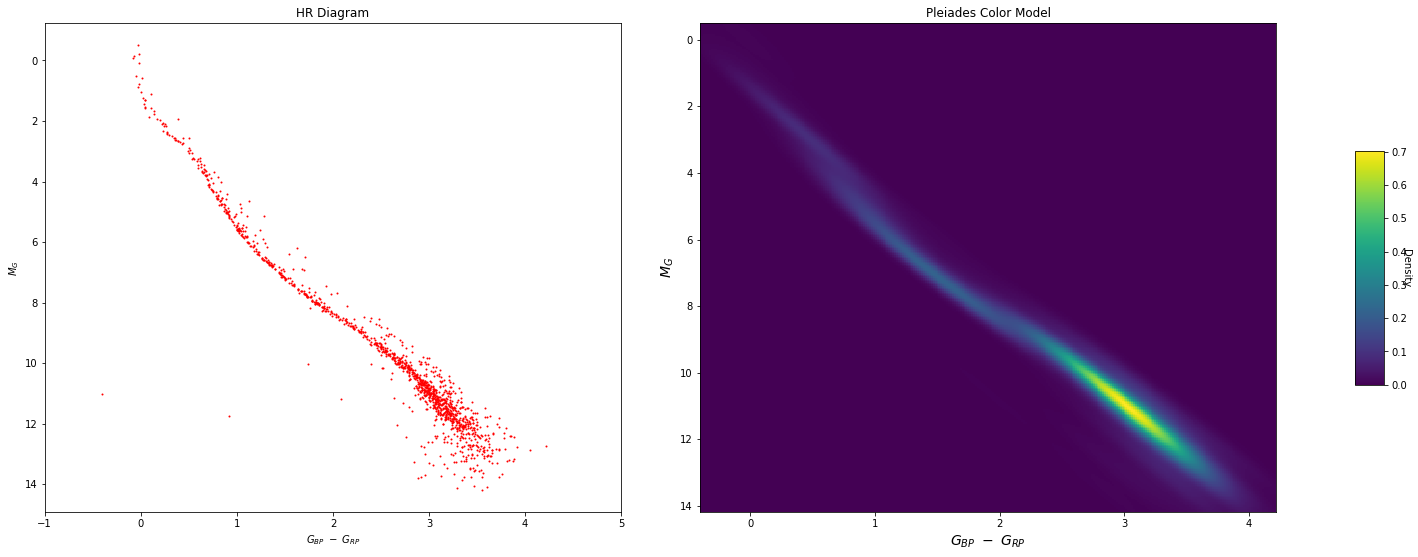

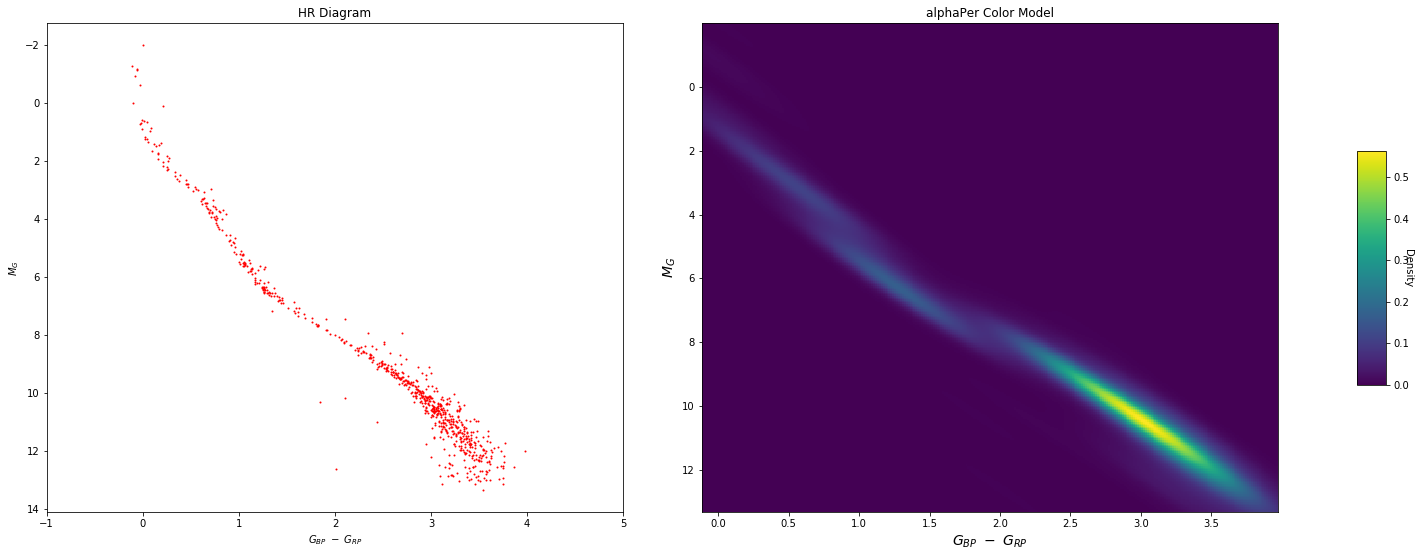

In [33]:

for cl in ['Pleiades','alphaPer']: #, 'Hyades', 'Praesepe']):
    fig = plt.figure(figsize=(24,9))
    gspec = fig.add_gridspec(4,3,width_ratios=[5,5,0.25])
    #axs = fig.subplots(1,2, sharex=True, sharey=True)
    
    cluster_members[cl].plot_hrdiagram(ax=fig.add_subplot(gspec[:,0]), color='red')
    cb = cm_models[cl].plot(ax=fig.add_subplot(gspec[:,1]))
    axs[0].set_title(f'Cluster: {cl} Known Members')
    cbar = plt.colorbar(cb, cax = fig.add_subplot(gspec[1:3,2]))
    cbar.set_label('Density', rotation=270)
    

## Training Set Accuracy

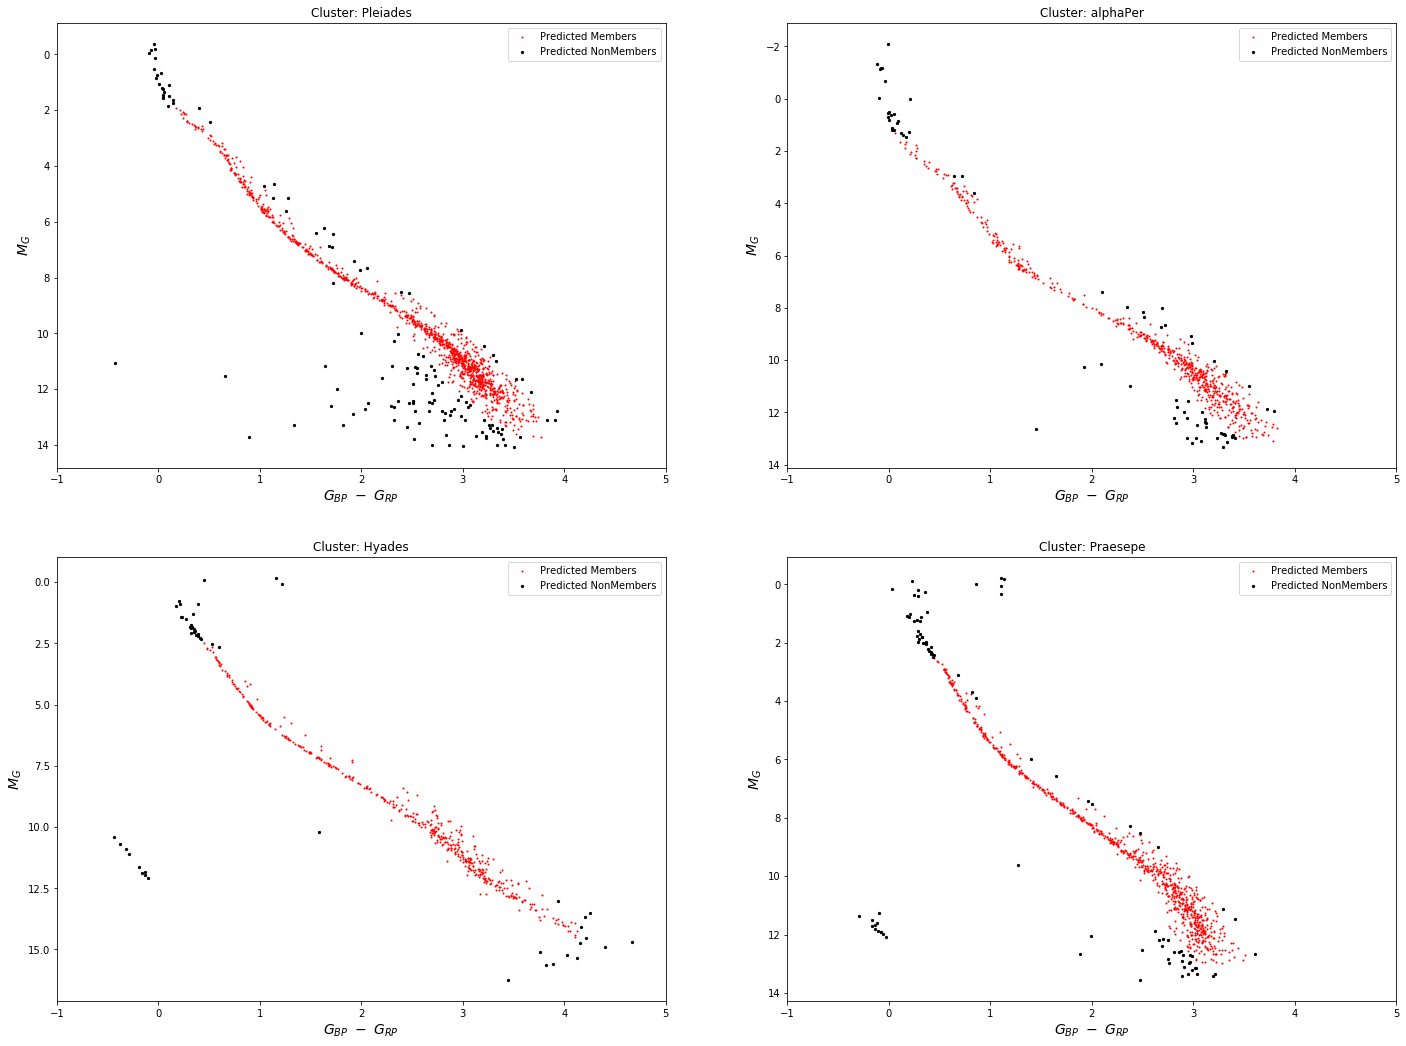

In [8]:
fig = plt.figure(figsize=(24,18))
axs = fig.subplots(2,2).flatten()
for ax, cl in zip(axs, ['Pleiades','alphaPer', 'Hyades', 'Praesepe']):
    cluster_known_members[cl].objs['CMok'] = cm_models[cl].predict(*cluster_known_members[cl].get_colors())
    cluster_known_members[cl].query('CMok').plot_hrdiagram(ax=ax, color='red',label='Predicted Members')
    cluster_known_members[cl].query('~CMok').plot_hrdiagram(ax=ax, color='black',s=5,label='Predicted NonMembers')
    ax.set_title(f'Cluster: {cl}')
    ax.legend()

In [10]:
for cl in ['Pleiades','alphaPer', 'Hyades', 'Praesepe']:
    print(f'{cl}: Members: {cluster_known_members[cl].objs.CMok.sum()}, NonMembers: {np.logical_not(cluster_known_members[cl].objs.CMok).sum()} Percent Positive: {cluster_known_members[cl].objs.CMok.sum()/len(cluster_known_members[cl].objs)}' )

Pleiades: Members: 1176, NonMembers: 150 Percent Positive: 0.8868778280542986
alphaPer: Members: 658, NonMembers: 82 Percent Positive: 0.8891891891891892
Hyades: Members: 459, NonMembers: 56 Percent Positive: 0.8912621359223301
Praesepe: Members: 839, NonMembers: 99 Percent Positive: 0.894456289978678


In [10]:
pleiades_known_members = cluster_known_members['Pleiades']
pleiades_cm = cm_model('Pleiades Color Model')
pleiades_cm.fit(*pleiades_known_members.get_colors())
is_member = pleiades_cm.predict(*pleiades_known_members.get_colors(), threshold=0.99)
pleiades_known_members.objs['IsMember'] = is_member

## Color Magnitude Model on Search Results

In [11]:
search_results = {}
for cl in cluster_names:
    ra_offset =  0*u.degree
    dec_offset = 0*u.degree
    search_radius = 13.0*u.degree

    ra = cluster_info.loc[cl]['coords'].ra + ra_offset
    dec = cluster_info.loc[cl]['coords'].dec + dec_offset
    
    dist = cluster_info.loc[cl]['coords'].distance.value
    minplx = 1000/(dist*1.25)
    maxplx = 1000/(dist*0.75)

    #grab some stars around the cluster center
    fs = gs(name=f'{cl} cone search', description=f'Conesearch around {cl}')

    fs.conesearch(ra, dec, search_radius, parallax=(minplx, maxplx))
    
    search_results[cl]= fs
    
    print(fs)

INFO: Query finished. [astroquery.utils.tap.core]
GaiaStars Object, Name: Hyades cone search, Description: Conesearch around Hyades, 914 objects
INFO: Query finished. [astroquery.utils.tap.core]
GaiaStars Object, Name: ComaBer cone search, Description: Conesearch around ComaBer, 2425 objects
INFO: Query finished. [astroquery.utils.tap.core]
GaiaStars Object, Name: Pleiades cone search, Description: Conesearch around Pleiades, 9831 objects
INFO: Query finished. [astroquery.utils.tap.core]
GaiaStars Object, Name: Praesepe cone search, Description: Conesearch around Praesepe, 17947 objects
INFO: Query finished. [astroquery.utils.tap.core]
GaiaStars Object, Name: alphaPer cone search, Description: Conesearch around alphaPer, 13796 objects
INFO: Query finished. [astroquery.utils.tap.core]
GaiaStars Object, Name: IC2391 cone search, Description: Conesearch around IC2391, 13820 objects
INFO: Query finished. [astroquery.utils.tap.core]
GaiaStars Object, Name: IC2602 cone search, Description: C

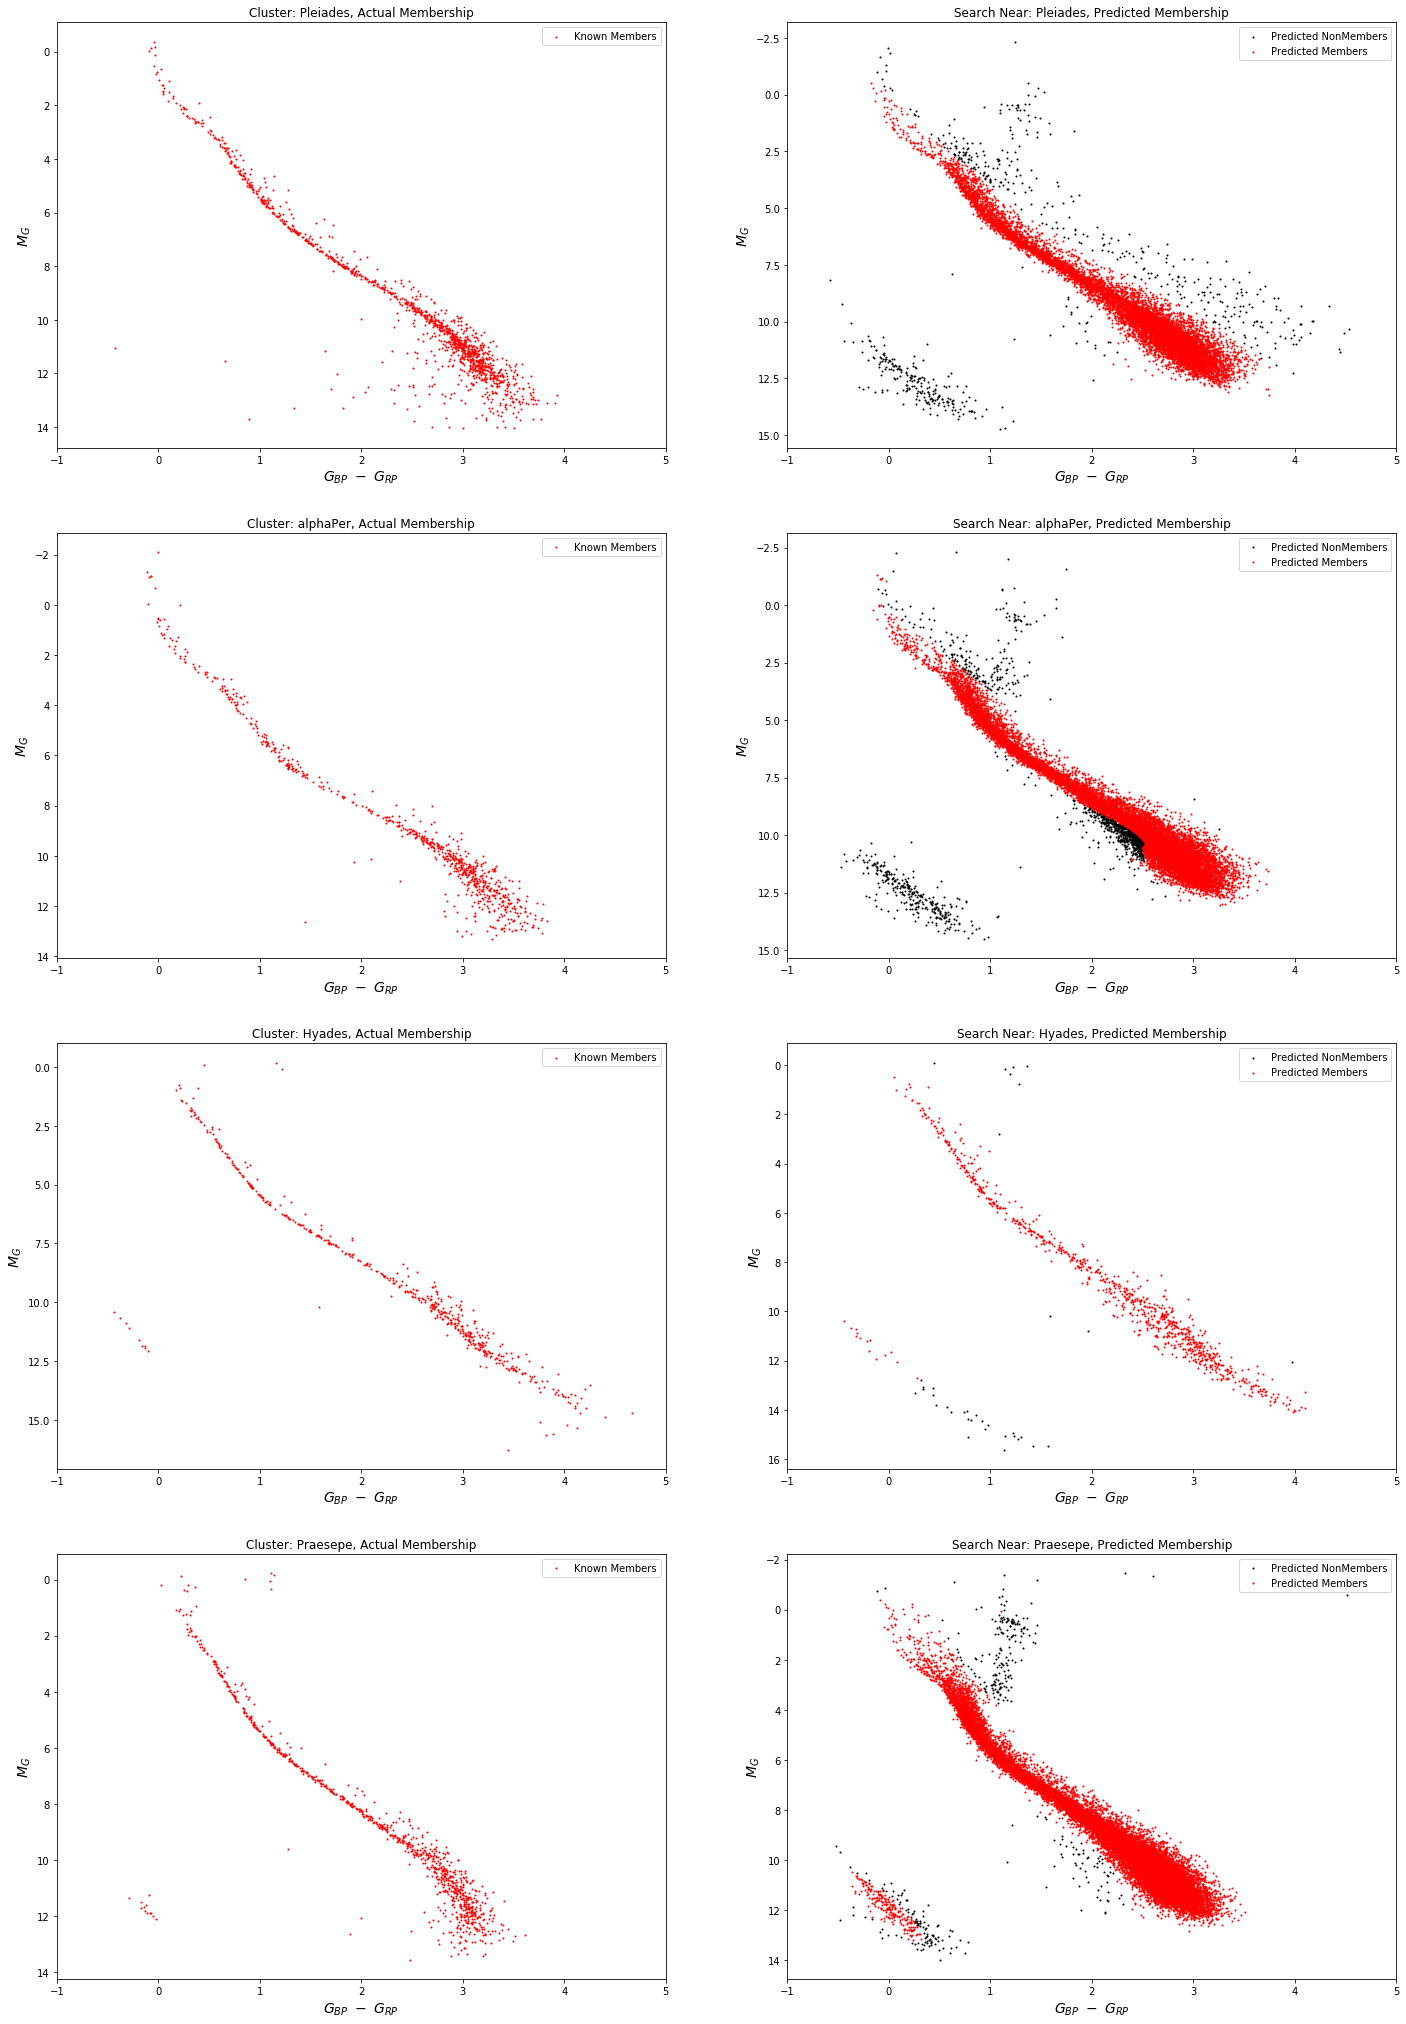

In [16]:
fig = plt.figure(figsize=(24,36))
axs = fig.subplots(4,2)
for ax, cl in zip(axs, ['Pleiades','alphaPer', 'Hyades', 'Praesepe']):
    cluster_known_members[cl].plot_hrdiagram(ax=ax[0], label='Known Members', color='red')
    ax[0].set_title(f'Cluster: {cl}, Actual Membership')
    ax[0].legend()
    
    
    search_results[cl].objs['CMok'] = cm_models[cl].predict(*search_results[cl].get_colors(), threshold=0.99)
    
    search_results[cl].query('~CMok').plot_hrdiagram(ax=ax[1], color='black',s=1,label='Predicted NonMembers')
    search_results[cl].query('CMok').plot_hrdiagram(ax=ax[1], color='red',label='Predicted Members')

    ax[1].set_title(f'Search Near: {cl}, Predicted Membership')
    ax[1].legend()